# Titanic Survival Prediction: 01 - Data Cleaning and Feature Engineering
*Date: TODO*
*Author: Jonas Lilletvedt*

--- 

## 1. Introduction and Setup

### 1.1. Objective

In this notebook we will focus on data cleaning and feature engineering. Building on the findings from our initial exploration in `00_initial_data_exploration.ipynb`, this notebook's primary objective is to construct a robust end-to-end pre-processing pipeline. This pipeline will transform raw data into clean, feature-rich dataset ready for modeling, while ensuring results are reproducible and free from data leakage.

To achieve this, our pipeline will systematically perform these tasks:
1.  **Data Cleaning and Imputation:**
    *   Address missing data in `Age`, `Embarked`.
    *   Normalize the positive skewed data in `Fare`.
2.  **Advanced Feature Engineering:**
    *   Extract `Title` from `Name` column to act as a proxy for age, sex, marriage- and social-status.
    *   Use `Surname` from `Name` and `Pclass` to identify families, and engineer a new feature `FamilySurvivalRate` representing the mean survival rate for that family, excluding the passenger themselves.
    *   Create a binned `FamilySize` feature from `SibSp` and `Parch`.
    *   Derive `Deck` (vertical location) and `Zone` (horizontal location) from `Cabin`.
    *   Bin the `Age` feature to better represent the non-linear relationship to `Survived`.

The entire process will be wrapped in a `scikit-learn` `Pipeline`, implemented using a set of custom transformers for our distinct logic, and a `ColumnTransformer` for standard pre-processing tasks.

### 1.2 Recap of Findings from Exploratory Data Analysis

The preceding data analysis (`00_initial_data_exploration.ipynb`) revealed several key insights and quality issues that will determine our work here:

**Key Predictive Relationships:**
*   **Dominant Predictors:** `Sex` and `Pclass` were found to be the strongest predictor for survival.
    *   Females had a vastly higher survival rate (~74%) then males (~18%).
    *   There was a clear linear relationship between passenger class and survival rate. First class passengers had a survival rate of ~63% compared to second and first class passengers ~63% and ~24% respectively.

**Data Quality and Structural Issues:**
*   **Missing Data:** Multiple columns were missing significant amounts of data.
    *   `Cabin`(~77% missing)
    *   `Age` (~20% missing)
    *   `Embarked` (2 missing values)
*   **Outliers and Skewness:** The `Fare` column show a substantial discrepancy in the 75% quantile (31$) and max value (512$).
*   **Features Requiring Transformation:** The columns `Name`, `Ticket` and `Cabin` are not suitable for direct use but contain valuable information that can be extracted:
    *   `Name` can be deconstructed to extract `Title` (a proxy for sex, age, marriage- and social-status) and `Surname` for family identification. 
    *   From `Cabin` we can gather positional information for `Deck` (vertical location) and `Zone` (horizontal location).
    *   `SibSp` and `Parch`can be combined for a more powerful feature, `FamilySize`.

## 2. Data Loading and Setup

---

The first step in this notebook is to load in the correct libraries followed by the train and test datasets.

All modifications will be applied to both the `train` and `test` sets for consistency. To prevent data leakage and ensure our model's performance is realistically evaluated, all transformations parameters -- such as values for imputation or scaling factors -- will be extracted solely from the `train` dataset. The test must and will only be used for model evaluation, and not influence any part of the data analysis or pre-processing steps.

### 2.1. Library Imports

In [256]:
# Import necessary libraries

# Data manipulation and analysis
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn tools for preprocessing and modeling
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin

### 2.2. Load Datasets

In [257]:
# Load datasets
df_train = pd.read_csv('../data/01_raw/train.csv')
df_test = pd.read_csv('../data/01_raw/test.csv')

### 2.3. Initial Inspection 

A quick inspection to check the dataset are loaded properly and expected. 

**Dataset Shapes:**

In [258]:
# Check shape of each dataset
print(f'Training data shape: {df_train.shape}')
print(f'Test data shape: {df_test.shape}')

Training data shape: (891, 12)
Test data shape: (418, 11)


**Data Preview:**

In [259]:
# Check five first rows of `df_train`
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [260]:
# Check five first rows of `df_test`
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


**Data Types and Missing Values:**

In [261]:
# Types and missing values for `df_train`
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [262]:
# Types and missing values for `df_test`
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


Unlike our train set we also have missing values in `Fare` in addition to `Cabin` and `Age`. 

Now that we have gotten a feel for the data, and checked everything is working as expected we will move on to `Data Cleaning and Imputation`.

### 2.4. Initial Findings and Plan Adjustments

The inspection confirms the missing values in `Age`, `Cabin` and `Embarked` in the training set, as we expected from the EDA.

Alongside the previous findings we have also discovered missing values in the test set, this include `Age` and `Cabin` similar to the train set. In addition we the test set have one missing value in `Fare`. Thus, our pipeline must be able to handle `Fare` imputation along the previous transformers.

## 3. Exploratory Feature Engineering and Validation

--- 

Feature selection is an important step before pipeline development. We will therefore perform an exploratory analysis to evaluate the value of the proposed engineered features.

Thus, this section will act as an 'scratchpad' for our feature engineering ideas. 

### 3.1. Evaluating the `Title` feature

We will begin our feature engineering exploration with `Title`. As hypothesized in the introduction, a passenger's title has the potential to be a strong proxy for age, and survival. 

It is crucial to evaluate `Title` first, because our `Age` imputation strategy will depend on it. We will analyze `Title`'s relationship with both variables accordingly.

In [263]:
# Make copy for scratchpad
df_scratch = df_train.copy()

# Add new columns
df_scratch['Surname_feat'] = df_scratch['Name'].str.extract(pat=r'^(.+)?,', expand=False)
df_scratch['Title_feat'] = df_scratch['Name'].str.extract(pat=' ([A-Za-z]+\.)', expand=False)

# Check it worked as expected
#Check for null values
print(f'''Missing Surnames: {df_scratch['Surname_feat'].isnull().sum()}''')
print(f'''Missing Titles: {df_scratch['Title_feat'].isnull().sum()}''')

# Check five first strings
df_scratch.head()

Missing Surnames: 0
Missing Titles: 0


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname_feat,Title_feat
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund,Mr.
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings,Mrs.
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen,Miss.
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Futrelle,Mrs.
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Allen,Mr.


In [264]:
# We will now change all *titles* with less then 10 occurrences to a new class 'Rare'
# Rare titles
rare_titles = df_scratch['Title_feat'].value_counts()[lambda x: x < 10]
# Swap to 'Rare'
df_scratch['Title_feat'] = df_scratch['Title_feat'].apply(lambda x: 'Rare' if x in rare_titles else x)

The code is working as expected, we successfully extracted `Title` and `Surname`. We can now proceed with the analysis, the first step is to examine the relationship between `Title_feat` and `Survived`.

**A Note on Naming Conventions:** *For clarity, all new features engineered will be noted with `_feat` suffix to distinguish them from the original raw variables.*

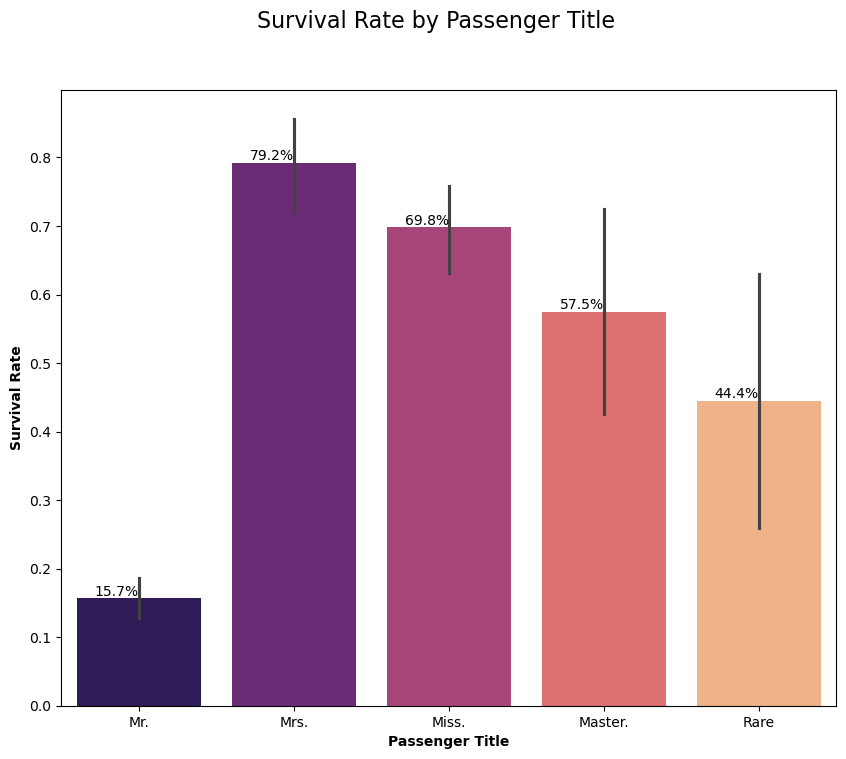

In [265]:
# Create figure
fig = plt.figure(figsize=(10, 8))

# Add plot
ax = sns.barplot(data=df_scratch, x='Title_feat', hue='Title_feat', y='Survived', palette='magma', legend=False)

# Labels
plt.suptitle('Survival Rate by Passenger Title', fontsize=16)
ax.set_ylabel('Survival Rate', fontweight='bold')
ax.set_xlabel('Passenger Title', fontweight='bold')

# Add percentage
for p in ax.patches:
    percentage = f'{p.get_height():.1%}'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(text=percentage, xy=(x,y), va='bottom', ha='right')
# Show plot
plt.show()


**Observation from `Survival Rate by Passenger Title`:** This looks very promising, each title have a distinct survival rate compared to the others.
*   **High Survival Groups:** Female-associated titles such as *Mrs.* (~79%) and *Miss.* (~70%) have a very high survival rate, this aligns with our previous findings in `00_initial_dat_exploration`. Young boys also seem to be favored in terms of survival (~58%). It is worth to note that young girls (*Miss.*) seem to be less prioritized than adult or and married women (*Mrs.*)
*   **Adult men (*Mr.*) are far below all other groups** with a survival rate of mere 15.7%.
*   **The *Rare* class** seem to be a mix of males and females, of all ages, due to their mediocre survival rate.

**Conclusion:** Passenger title is a promising predictive feature for `Survived`, and will be included for the final pipeline.

**Note for Further Iterations:** The *Rare* category could be further refined in a later iteration. Instead of grouping all uncommon titles, we could implement a more nuanced mapping, based on other features. 

For a example, a rule based system could be developed using domain knowledge:
*   A passenger with title *Dr.* could be re-categorized as an *Mr.* if male and *Mrs.* if female. This way we can make a clear distinction on sex, and can take use of the strong predictive ability of **Sex**.
*   Any male passengers with a *Rare* title would be placed in *Master.*, subsequently any young females would be placed in *Miss.*.

We will now analyze the relationship between `Title_feat` and `Age` to see if we can use `Title_feat` to make accurate imputations for `Age`.

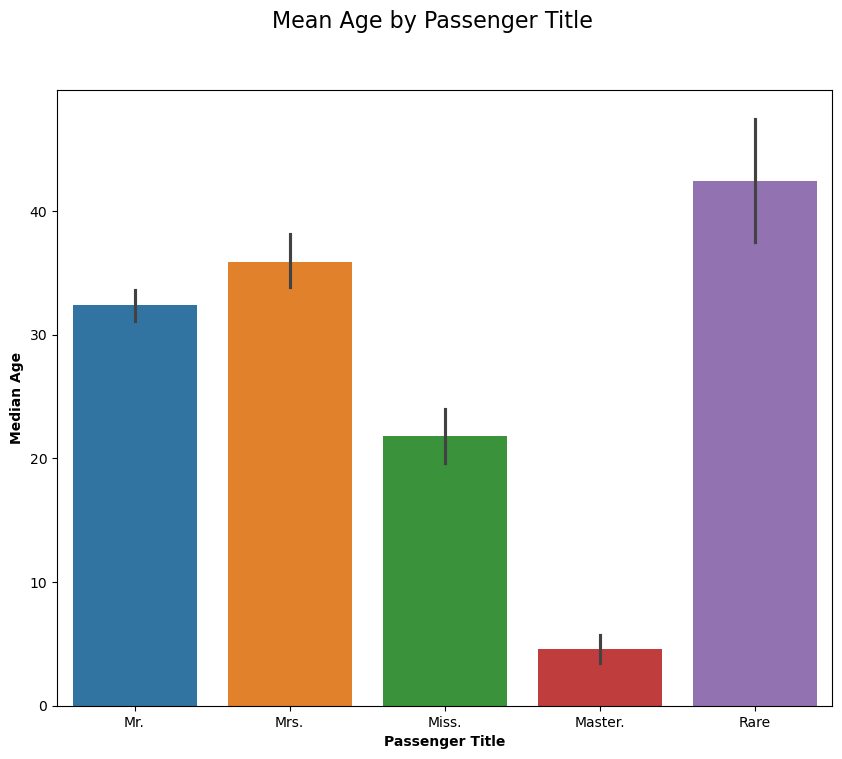

In [266]:
# Create figure
fig = plt.figure(figsize=(10,8))

# Add plot
ax = sns.barplot(data=df_scratch, x='Title_feat', y='Age', hue='Title_feat')

# Labels
ax.set_ylabel('Median Age', fontweight='bold')
ax.set_xlabel('Passenger Title', fontweight='bold')
plt.suptitle('Mean Age by Passenger Title', fontsize=16)

plt.show()

**Observations from `Mean Age by Passenger Title`:** The figure clearly show a clear association between passenger title and age. Furthermore, the variance is small across all titles. This indicates `Title_feat` as an excellent proxy for age, and is well suited for imputations. 

**Conclusion:** `Title_feat` is a great stratification variable for imputing `Age`, thus we will move forward as `Title_feat` as basis for imputation.

**A Note on the Previous Note:** `Rare` primarily looks to be a passenger title exclusively for elderly passengers, however it still might be beneficial to make a distinction between the sexes in the category.

### 3.2. Evaluating the `FamilySurvivalRate_feat` feature

We will now engineer and evaluate `FamilySurvivalRate_feat`, the new feature could have a strong predictive value, but is also inclined to cause noise and have high-variance. Each identifiable family is likely between 1-10 members in size. Small families are therefore subject to high variance, and noise.

To mitigate this issue we will explore different approaches, such as *smoothing*.

In [267]:
# Create `FamilyID` -- We will use `Surname` extracted in the previous section together with `Pclass`

# Print number of distinct surnames, the amount of unique family_id should be a tiny bit higher since it distinguishes between surnames in different passenger classes
print(f'''Count of distinct surnames: {df_scratch['Surname_feat'].nunique()}''')

# Add family_id
df_scratch['FamilyID_temp'] = df_scratch['Surname_feat'] + '_' + df_scratch['Pclass'].astype(str)

# Factorize famile_id for faster operations
df_scratch['FamilyID_temp'], unique = pd.factorize(df_scratch['FamilyID_temp'])

# Check to see if count of distinct ids are as expected
print(f'''Count of distinct family ID's: {df_scratch['FamilyID_temp'].nunique()}''')

# Check after operations
df_scratch.head()

Count of distinct surnames: 667
Count of distinct family ID's: 686


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname_feat,Title_feat,FamilyID_temp
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund,Mr.,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings,Mrs.,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen,Miss.,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Futrelle,Mrs.,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Allen,Mr.,4


A quick sanity check reveals that the number of distinct `FamilyID_feat`'s is slightly higher than the number of distinct `Surname_feat`'s. This confirms that our `FamilyID_feat` has successfully distinguished between families with the same surname but different `Pclass` values.

We will now move on to calculating and assigning family survival rate. To avoid data leakage it is crucial to not include the passenger's on survival / death in the calculation.

In [268]:
# How to calculate? Count all people with same id, and how many survived, remove one from ids and if survived one from the survived.
family_stats = df_scratch.groupby('FamilyID_temp').agg(
    FamilySize = ('Survived', 'size'),
    FamilySurvivalCount = ('Survived', 'sum')
)
df_scratch['FamilySize_temp'] = df_scratch['FamilyID_temp'].map(family_stats['FamilySize'])
df_scratch['FamilySurvivalCount_temp'] = df_scratch['FamilyID_temp'].map(family_stats['FamilySurvivalCount'])
# To avoid division by zero
epsilon = 1e-6
df_scratch['FamilySurvivalRate_feat'] = (df_scratch['FamilySurvivalCount_temp'] - df_scratch['Survived']) / (df_scratch['FamilySize_temp'] - 1 +  epsilon)
# Check to see it worked as expected
df_scratch.head(20)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname_feat,Title_feat,FamilyID_temp,FamilySize_temp,FamilySurvivalCount_temp,FamilySurvivalRate_feat
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund,Mr.,0,2,0,0.000000
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings,Mrs.,1,1,1,0.000000
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen,Miss.,2,1,1,0.000000
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Futrelle,Mrs.,3,2,1,0.000000
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Allen,Mr.,4,1,0,0.000000
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,Moran,Mr.,5,3,1,0.500000
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,McCarthy,Mr.,6,1,0,0.000000
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,Palsson,Master.,7,4,0,0.000000
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,Johnson,Mrs.,8,6,3,0.400000
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,Nasser,Mrs.,9,2,1,0.000000


In [269]:
# Drop the temp columns, to make the df easier to read
df_scratch = df_scratch.drop(['FamilySize_temp', 'FamilySurvivalCount_temp', 'FamilyID_temp'], axis=1)

We will now visualize the `FamilySurvivalRate_feat` to see if it should be a part of the final pipeline.

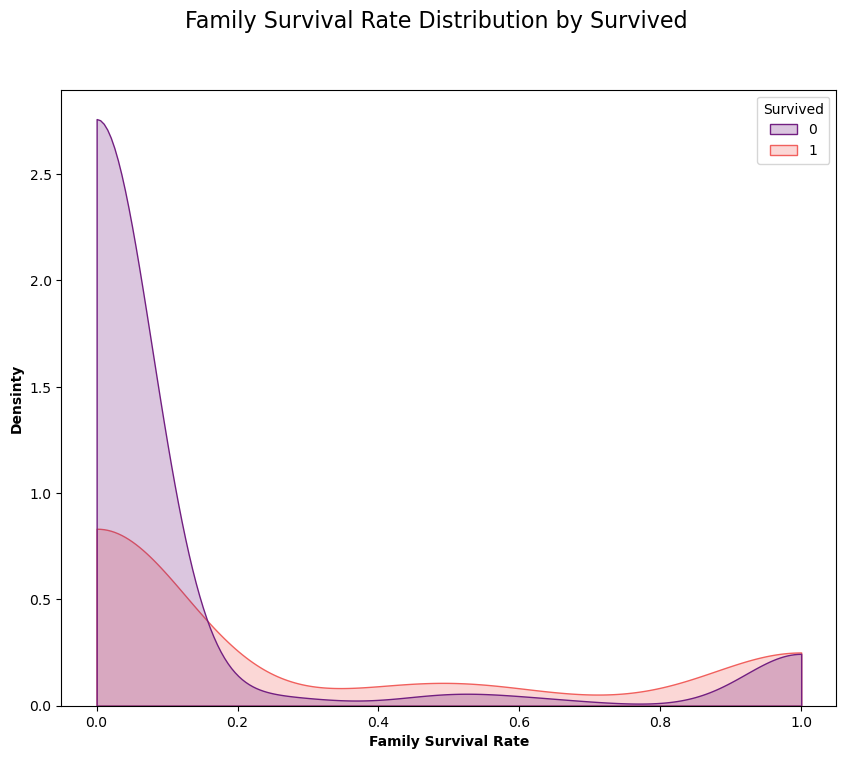

In [270]:
# Create figure
fig = plt.figure(figsize=(10, 8))

# Add plot
sns.kdeplot(data=df_scratch, x='FamilySurvivalRate_feat', hue='Survived', palette='magma', fill=True, cut=0)

# Labels
plt.suptitle('Family Survival Rate Distribution by Survived', fontsize=16)
plt.xlabel('Family Survival Rate', fontweight='bold')
plt.ylabel('Densinty', fontweight='bold')

plt.show()

As shown in the figure, there is a clear difference between the two distributions. **Passengers who did not survive (blue) show an extremely high density at aa `FamilySurvivalRate_feat` of zero**. Conversely, **passengers who survived (orange) have a much more prominent distribution at higher survival rate**. Thus we will keep this feature for the final pipeline. 

We have now engineered the initial `FamilySurvivalRate_feat`. However this blueprint needs to be made more robust for the final pipeline. 

The primary issues to address are:
1.  **Handling Test Data:** Our calculation must be adapted to the missing `Survived` column in the test set.
2.  **Mitigating Noise:** The current feature is very sensitive to noise, thus having high-variance, especially for small families. We will apply a **smoothing** technique to the calculated rates, to reduce noise.

These steps will ensure the feature is more robust and generalizable.

### 3.3. Evaluating the `AgeBinned_feat` feature

The next step is to evaluate if a binned-age feature raises the predictive value of `Age`. Since we found `Title_feat` to be a valid stratification variable and baseline for `Age` imputation, we will primarily focus on `Age` and `AgeBinned_feat` predictive value after imputation. All missing `Age` values need to be imputed and our analyze should reflect this.

Previously, we considered using both `Title_feat` and `Pclass` to impute `Age`. However, due to the discovery of `Title_feat` being a strong proxy for age this appears to be unnecessary, mainly due to the low variance. In addition these minor errors in imputation is unlikely to have an impact after binning.

In [271]:
# Impute missing values for `Age`
# Calculate median for each Passenger Title -- This value will be used for imputation
median_age_per_title = df_scratch.groupby('Title_feat')['Age'].median()

# Check median for each title
print(median_age_per_title)

# Impute missing values in `Age`
df_scratch['Age'] = df_scratch['Age'].fillna(df_scratch['Title_feat'].map(median_age_per_title))

# Pring count of missing values in `Age`
print(f'''Missing value count for Age: {df_scratch['Age'].isnull().sum()}''')

Title_feat
Master.     3.5
Miss.      21.0
Mr.        30.0
Mrs.       35.0
Rare       44.5
Name: Age, dtype: float64
Missing value count for Age: 0


Now that we have imputed the missing values in `Age` we will evaluate the predictive performance of `Age` against `AgeBinned_feat`.  

First, we need to engineer the new feature, `AgeBinned_feat`.

In [272]:
# Setting up bins
# Infant: 0-5, Child: 6-12, young-adult: 13-25, adult: 26-50, elder: 51->
bins_labels = ['Infant', 'Child', 'Young-Adult', 'Adult', 'Senior']
bins_edges = [0, 5, 12, 25, 50, np.inf]

# Add new age-binned feature
df_scratch['AgeBinned_feat'] = pd.cut(df_scratch['Age'], bins=bins_edges, labels=bins_labels, right=True, include_lowest=True)

# Check, we used tail since the first five rows only include adults
df_scratch.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname_feat,Title_feat,FamilySurvivalRate_feat,AgeBinned_feat
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S,Montvila,Rare,0.0,Adult
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S,Graham,Miss.,0.5,Young-Adult
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,21.0,1,2,W./C. 6607,23.45,NaN,S,Johnston,Miss.,0.0,Young-Adult
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C,Behr,Mr.,0.0,Adult
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q,Dooley,Mr.,0.0,Adult


We will now plot `AgeBinned_feat` predictive ability against `Age`.

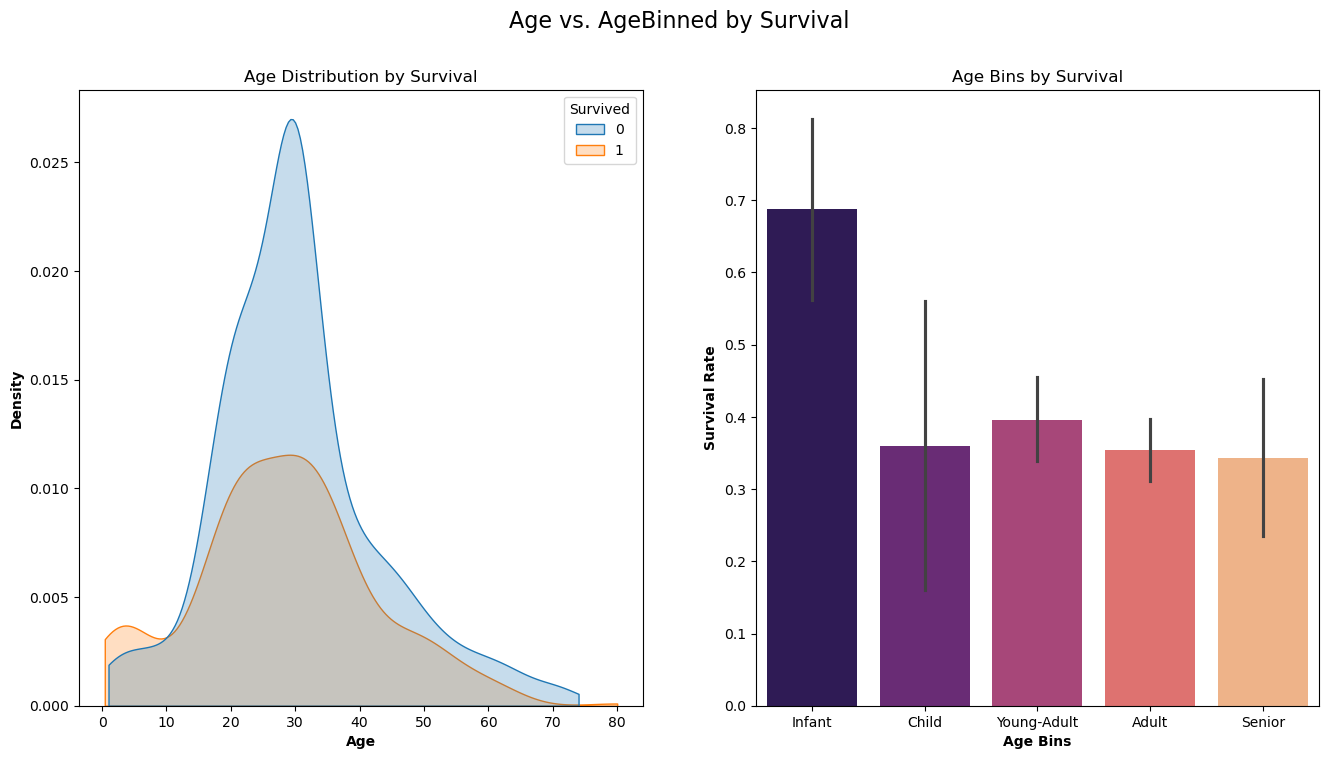

In [273]:
# Create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Add age distribution vs. survival
sns.kdeplot(data=df_scratch, x='Age', ax=ax1, hue='Survived', cut=0, fill=True)

# Add age-binned vs. survival
sns.barplot(data=df_scratch, x='AgeBinned_feat', y='Survived', hue='AgeBinned_feat', palette='magma')

# Add labels
plt.suptitle('Age vs. AgeBinned by Survival', fontsize=16)
ax1.set_title('Age Distribution by Survival', fontsize=12)
ax2.set_title('Age Bins by Survival', fontsize=12)
ax1.set_ylabel('Density', fontweight='bold')
ax1.set_xlabel('Age', fontweight='bold')
ax2.set_ylabel('Survival Rate', fontweight='bold')
ax2.set_xlabel('Age Bins', fontweight='bold')

plt.show()

To the left, we observe `Age`'s distribution by `Survived` status. As shown in the `00_initial_data_exploration`, `Age` exhibits a clear non-linear relationship to `Survived`. 

This non-linear trend is further confirmed by the right plot, visualizing survival rate across age-bins. `AgeBinned_feat` effectively captures this non-linear relationship. 

Using `AgeBinned_feat` instead of the continuos `Age` will allow simpler models to better leverage this pattern, improving both performance and interpretability.

### 3.4. Evaluating the `FamilySize_feat`

We will noe move on to engineering and evaluating `FamilySize_feat`. It is crucial that the new feature performance better then `SibSp` and `Parch` separately to justify its inclusion.

To start `FamilySize_feat` will be a numerical feature. However we will analyze its predictive value as categorical feature to determine which representation yields the best results for our models.

In [274]:
# Creating FamilySize 
# We can either create familySize with or without including the passenger themselves, it does not matter
# However from an outsider perspective, it is more understandable to add the passenger themselves
df_scratch['FamilySize_feat'] = df_scratch['SibSp'] + df_scratch['Parch'] + 1

# Check it worked as expected
df_scratch.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname_feat,Title_feat,FamilySurvivalRate_feat,AgeBinned_feat,FamilySize_feat
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund,Mr.,0.0,Young-Adult,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings,Mrs.,0.0,Adult,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen,Miss.,0.0,Adult,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Futrelle,Mrs.,0.0,Adult,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Allen,Mr.,0.0,Adult,1


The next step is to visualize the predictive value of our engineered feature `FamilySize_feat` to see if it holds a stronger predictive value than `SibSp` and `Parch` separately. 

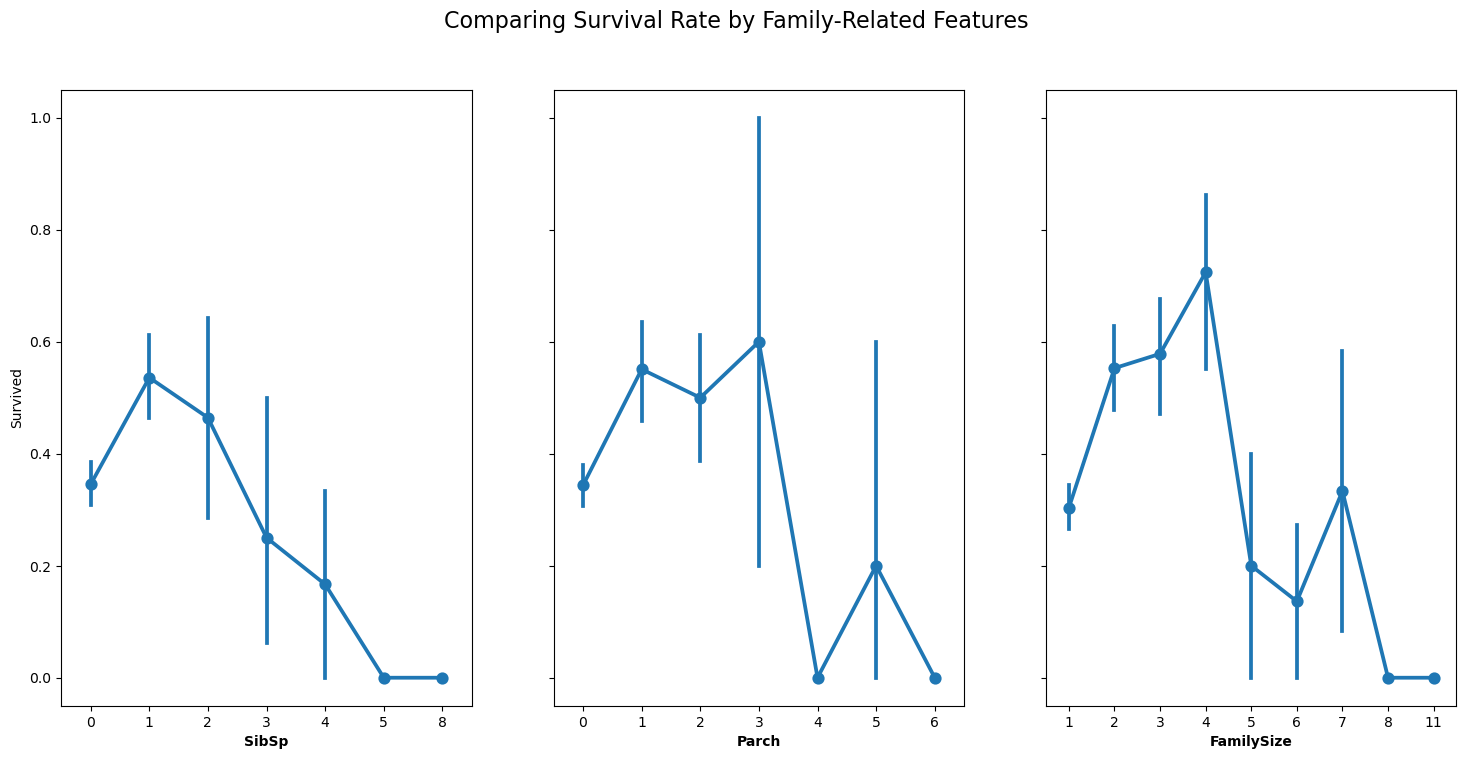

In [275]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 8), sharey=True)

plt.suptitle('Comparing Survival Rate by Family-Related Features', fontsize=16)

sns.pointplot(data=df_scratch, x='SibSp', y ='Survived', ax=ax1)
ax1.set_xlabel('SibSp', fontweight='bold')

sns.pointplot(data=df_scratch, x='Parch', y ='Survived', ax=ax2)
ax2.set_xlabel('Parch', fontweight='bold')

sns.pointplot(data=df_scratch, x='FamilySize_feat', y ='Survived', ax=ax3)
ax3.set_xlabel('FamilySize', fontweight='bold')

plt.show()

`SibSp` shows the clearest trend for survival, with rates increasing from up to two sibling/spouses before declining. In contrast, `Parch` displays a more erratic patter: survival rises from 0 to 1, fluctuates between 2 and 3, drops sharply at 4 and rises at 4, then falls again at 6. While `FamilySize` helps smooth some of this inconsistency, it still inherits much of `Parch`'s chaotic structure. Overall, I cannot say `FamilySize`performs better than `SibSp` and `Parch`.

Since we struggle finding the best feature we do not have to decide ourselves, instead we can use a model to determine the predictive value of each feature.

In [276]:
# Import
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Train three simple RandomForestClassifiers

# Baseline features
baseline_features = ['Pclass', 'Sex', 'Title_feat', 'Fare', 'Age']

# Create base df
df_base = pd.get_dummies(df_scratch[baseline_features], columns=['Sex', 'Title_feat'], drop_first=True)
df_base.fillna(df_train['Age'].median(), inplace=True)

y = df_scratch['Survived']

# Features we will explore -- SibSp, Parch, FamilySize
# Create on df for each
base_features_plus_sibsp = df_base.copy()
base_features_plus_sibsp['SibSp'] = df_scratch['SibSp']

base_features_plus_parch = df_base.copy()
base_features_plus_parch['Parch'] = df_scratch['Parch']

base_features_plus_sibsp_parch = df_base.copy()
base_features_plus_sibsp_parch[['Parch', 'SibSp']] = df_scratch[['Parch', 'SibSp']]

base_features_plus_familysize = df_base.copy()
base_features_plus_familysize['FamilySize'] = df_scratch['FamilySize_feat']

# Run three separate models --  one for each df feature set
# Create model
model = RandomForestClassifier(n_estimators=100, random_state=43)

# Baseline
score_base = cross_val_score(model, df_base, y, cv=5, scoring='accuracy').mean()

# 2. Check SibSp
score_sibsp = cross_val_score(model, base_features_plus_sibsp, y, cv=5, scoring='accuracy').mean()

# 3. Check Parch
score_parch = cross_val_score(model, base_features_plus_parch, y, cv=5, scoring='accuracy').mean()

# 4. Check SibSp and Parch
score_sibsp_parch = cross_val_score(model, base_features_plus_sibsp_parch, y, cv=5, scoring='accuracy').mean()

# 5. Check FamilySize
score_familysize = cross_val_score(model, base_features_plus_familysize, y, cv=5, scoring='accuracy').mean()

print(f'''Base accuracy score: {score_base}''')
print(f'''SibSp accuracy score: {score_sibsp}''')
print(f'''Parch accuracy score: {score_parch}''')
print(f'''SibSp and Parch accuracy score: {score_sibsp_parch}''')
print(f'''FamilySize accuracy score: {score_familysize}''')

Base accuracy score: 0.8204130311970372
SibSp accuracy score: 0.812585525076894
Parch accuracy score: 0.815956311593748
SibSp and Parch accuracy score: 0.8080911430544223
FamilySize accuracy score: 0.8137028435126483


**Initial Findings: Family Features Do NOT Improve Accuracy:**

The evaluation results are clear, the baseline model without any explicit family features achieved the highest accuracy (**0.8204**). Adding `FamilySize`, `SibSp`, `Parch`, or a combination of the two last consistently resulted in a lower cross-validation score. 

This suggests the baseline features already capture the necessary information regarding family structure, including any of the features up for evaluation only seem to add noise. 

I hypothesize the new engineered `Title_feat` may have an effect in the performance of the family-feature, as it likely captures some similar information about family structure (e.g., *Master.* for young boys or *Mrs.* for married women) but cleaner and less noisy. We will run the same experiment as over, without including `Title_feat` to test the hypothesis. 

In [277]:
# We will conduct the exact same experiment one more time, dropping `Title_feat`
# Train three simple RandomForestClassifiers

# Baseline features
baseline_features = ['Pclass', 'Sex', 'Fare', 'Age']

# Create base df
df_base = pd.get_dummies(df_scratch[baseline_features], columns=['Sex'], drop_first=True)
df_base.fillna(df_train['Age'].median(), inplace=True)

y = df_scratch['Survived']

# Features we will explore -- SibSp, Parch, FamilySize
# Create on df for each
base_features_plus_sibsp = df_base.copy()
base_features_plus_sibsp['SibSp'] = df_scratch['SibSp']

base_features_plus_parch = df_base.copy()
base_features_plus_parch['Parch'] = df_scratch['Parch']

base_features_plus_sibsp_parch = df_base.copy()
base_features_plus_sibsp_parch[['Parch', 'SibSp']] = df_scratch[['Parch', 'SibSp']]

base_features_plus_familysize = df_base.copy()
base_features_plus_familysize['FamilySize'] = df_scratch['FamilySize_feat']

# Run three separate models --  one for each df feature set
# Create model
model = RandomForestClassifier(n_estimators=100, random_state=43)

# Baseline
score_base = cross_val_score(model, df_base, y, cv=5, scoring='accuracy').mean()

# 2. Check SibSp
score_sibsp = cross_val_score(model, base_features_plus_sibsp, y, cv=5, scoring='accuracy').mean()

# 3. Check Parch
score_parch = cross_val_score(model, base_features_plus_parch, y, cv=5, scoring='accuracy').mean()

# 4. Check SibSp and Parch
score_sibsp_parch = cross_val_score(model, base_features_plus_sibsp_parch, y, cv=5, scoring='accuracy').mean()

# 5. Check FamilySize
score_familysize = cross_val_score(model, base_features_plus_familysize, y, cv=5, scoring='accuracy').mean()

print(f'''Base accuracy score: {score_base}''')
print(f'''SibSp accuracy score: {score_sibsp}''')
print(f'''Parch accuracy score: {score_parch}''')
print(f'''SibSp and Parch accuracy score: {score_sibsp_parch}''')
print(f'''FamilySize accuracy score: {score_familysize}''')

Base accuracy score: 0.8137153976523759
SibSp accuracy score: 0.8069801016885318
Parch accuracy score: 0.8103634423451134
SibSp and Parch accuracy score: 0.8059004456719603
FamilySize accuracy score: 0.8159688657334756


**Hypothesis Confirmed:** After removing `Title_feat`, the `FamilySize` feature in addition to the base feature no produces the best result (accuracy of **0.816**). `Title_feat` with base is still by far the best combination of features.

**Conclusion:** As the model performs worse after including family features, we will drop these features in the final pipeline. In addition to the better accuracy score, removing features improve model interpretability and use less hardware.

**Note On Family Features:** The family features do hold predictive value as shown in the last example, however our previously engineered `Title_feat` triumphs, resulting in them only introducing noise.

### 3.5. Evaluating `Deck_feat` and `Zone_feat` 

The last and next step for the `Exploratory Feature Engineering and Validation` is to prototype and evaluate `Deck_feat` and `Zone_feat` predictive value.

In [278]:
# Creating Deck and Zone
# Creating deck
df_scratch['Deck_feat'] = df_scratch['Cabin'].str.extract(pat='(^[A-Za-z])', expand=False)

# Fill missing Deck values with 'U' -- We could impute using  'Pclass' later
df_scratch['Deck_feat'] = df_scratch['Deck_feat'].fillna('U')

# Creating zone
df_scratch['Zone_feat'] = pd.to_numeric(df_scratch['Cabin'].str.extract(pat='[A-Za-z]*([0-9]+)', expand=False))

# Check it worked as expected
df_scratch.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname_feat,Title_feat,FamilySurvivalRate_feat,AgeBinned_feat,FamilySize_feat,Deck_feat,Zone_feat
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund,Mr.,0.0,Young-Adult,2,U,NaN
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings,Mrs.,0.0,Adult,2,C,85.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen,Miss.,0.0,Adult,1,U,NaN
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Futrelle,Mrs.,0.0,Adult,2,C,123.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Allen,Mr.,0.0,Adult,1,U,NaN


It worked as expected, lets do a quick visualization of the initial features. Further, we will convert zone into a categorical variable introducing *forw*, *mid*, *back* and *unknown*. We will also do a quick comparison between the current `Zone_feat` and the proposed. In the end, we will decide which features to keep, if any.

First visualization will be a univariate analysis of the distribution of both features.

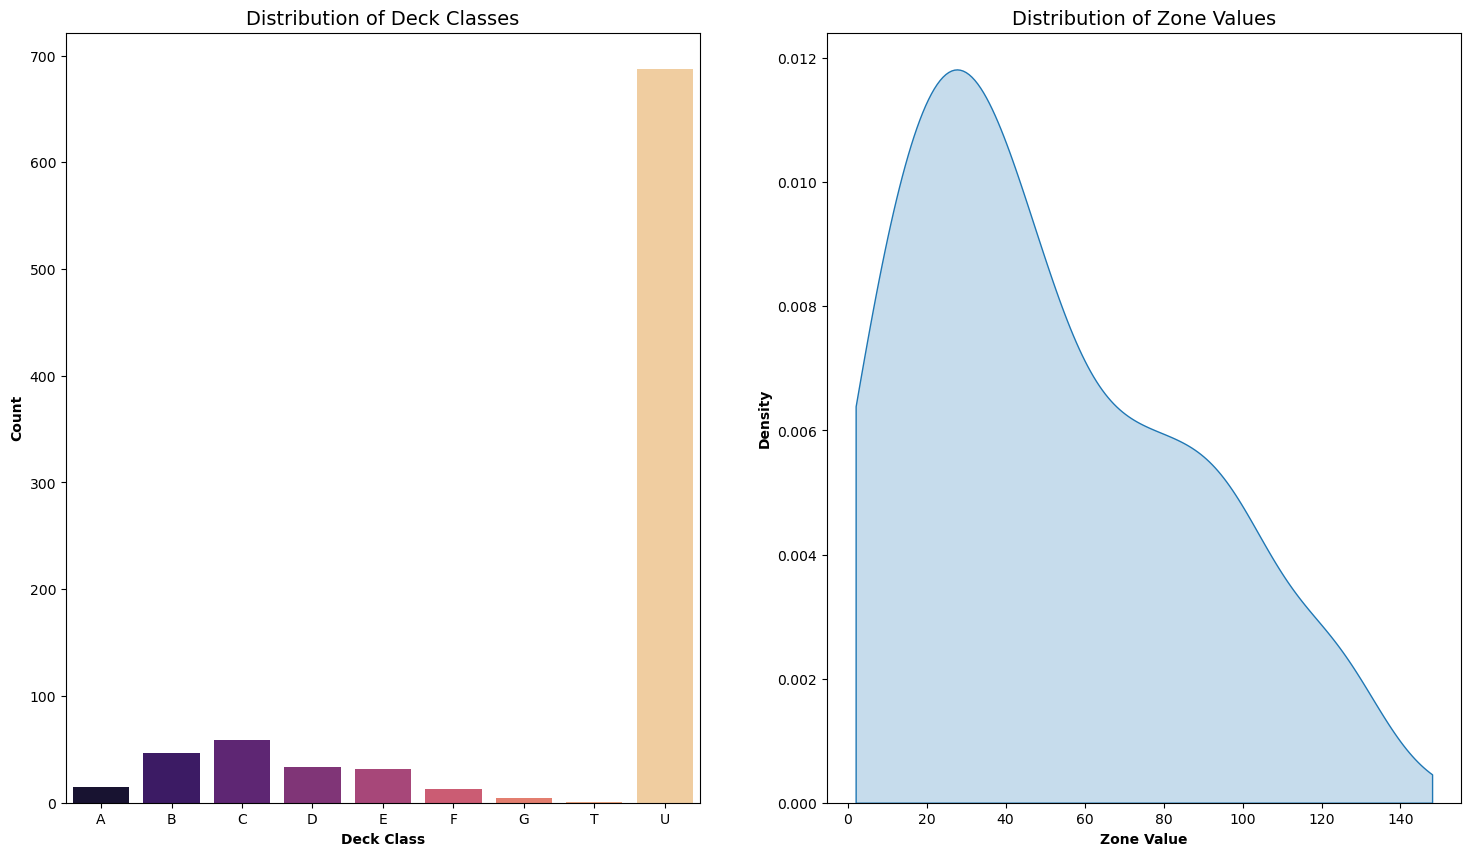

In [279]:
# Visualization of the two variables
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))

# Add barplot for deck
sns.countplot(data=df_scratch.sort_values('Deck_feat'), x='Deck_feat', hue='Deck_feat', ax=ax1, palette='magma')

# Add kde plot for zone
sns.kdeplot(data=df_scratch, x='Zone_feat', ax=ax2, cut=0, fill=True)

# Labels
ax1.set_title('Distribution of Deck Classes', fontsize=14)
ax2.set_title('Distribution of Zone Values', fontsize=14)
ax1.set_xlabel('Deck Class', fontweight='bold')
ax2.set_xlabel('Zone Value', fontweight='bold')
ax1.set_ylabel('Count', fontweight='bold')
ax2.set_ylabel('Density', fontweight='bold')

plt.show()

The plot to the left shows the distribution of passengers across the engineered feature `Deck_feat`. As expected from our initial EDA, the *U* (Unknown) category dominates, representing the large amount of missing values from `Cabin`. Among the decks, *C*, *B*, *D*, and *E* are most frequent.

The critical question is wether the missing values are random. It is possible that the observed distribution is not representative of the true distribution, obviously disregarding *U*. One possible skewness could arise from certain deck classes being more likely to be recorded. As an example maybe higher classes were more likely to be recorded to keep better track of passengers with higher socioeconomic status. We can investigate if the distribution of deck classes are accurate using `Pclass` or `Fare` as a proxy. The outcome of that analysis will determine wether *U* as a meaningful class, or if we should try to impute these missing values based on other features.

The plot to the right shows the density of the continuos `Zone_feat` (cabin number) for passengers where it is known. The distributions is centered around values around 20-60 with a mean of 40. 

As with `Deck_feat`, we must consider if the missing zone numbers are random. However, unlike `Deck_feat` we do not have a strong proxy to investigate or impute the missing values. Therefore, a more robust strategy is to convert the numerical feature into a categorical feature with following classes, *forw*, *mid*, *back* and *unknown*. Embracing, the missing values, possibly identifying an underlying pattern with *unknown* and `Survived`.

We will know conduct a bivariate analysis of `Deck_feat` and `Zone_feat` against `Survived`, this will determine wether the new features will be included in the final pipeline.

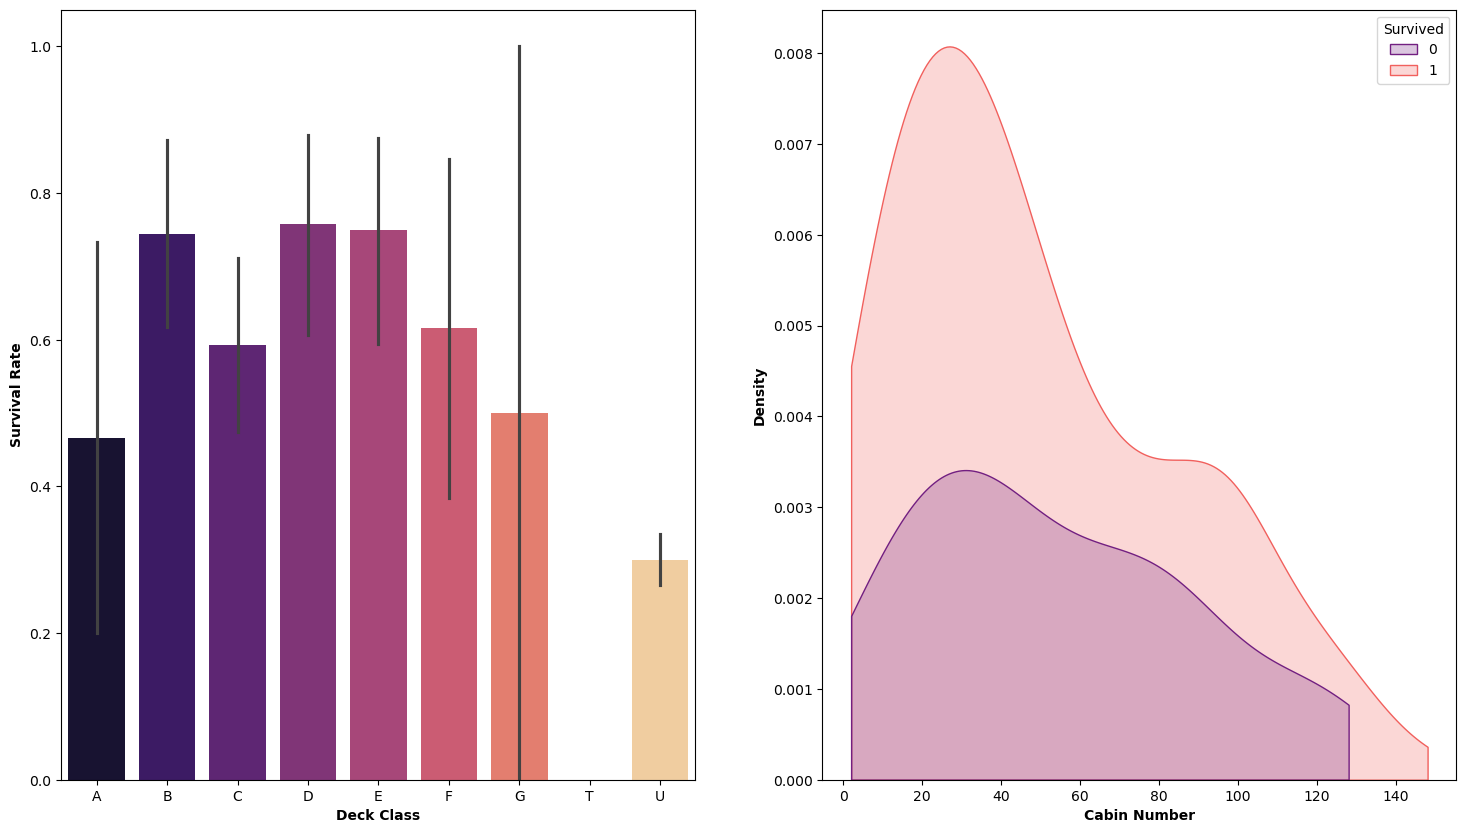

In [280]:
# Create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,10))

# Add Deck Plot
sns.barplot(data=df_scratch.sort_values('Deck_feat'), x='Deck_feat', y='Survived', hue='Deck_feat', palette='magma', ax=ax1)

# Add Zone plot
sns.kdeplot(data=df_scratch, x='Zone_feat', hue='Survived', cut=0, palette='magma', ax=ax2, fill=True)

# Labels
ax1.set_ylabel('Survival Rate', fontweight='bold')
ax2.set_ylabel('Density', fontweight='bold')
ax1.set_xlabel('Deck Class', fontweight='bold')
ax2.set_xlabel('Cabin Number', fontweight='bold')

plt.show()

**Observations from Feature-Engineered `Cabin` Plots:**

These plots confirm that a passenger's physical location on the ship was a critical factor for survival.

*   **Vertical Position (`Deck_feat`):**
The bar plot to the left clearly shows survival was not uniform across classes, even in decks with mostly the same passenger classes, there is a substantial discrepancy in survival rate. Deck classes *A* and *B* are almost entirely made up of first-class passengers however *A* (~0.47) has a significant lower survival rate then *B* (~0.75). This proves that a passenger's vertical location provided a advantage or disadvantage to survival.
*   **Horizontal Position (`Zone_feat`):**
The density plot to the right, which visualized the cabin number, reveals another predictive pattern. Non-survivors are heavily centered around cabin number 40, while survivors are more evenly spread out.

**Conclusion:** The vertical and horizontal location of passengers played a crucial role in survival, we will therefore include these for the final pipeline. Before we move on we will see if binning zone emphasize the pattern.

**Note On Decks For Pipeline:** To avoid noise in `Deck_feat` we could bin some of the classes together, classes with less than 10 passengers could also be moved to unknown.

Earlier, I have mentioned the option in binning `Zone_feat` in to *forw*, *mid*, *back*, and *unknown*. However the visualization made it clear that this is likely not the optimal way to split the continuos cabin numbers. We will therefore instead split the in to four zones, in addition to one category for unknown. 

<Axes: xlabel='ZoneBinned_feat8', ylabel='Survived'>

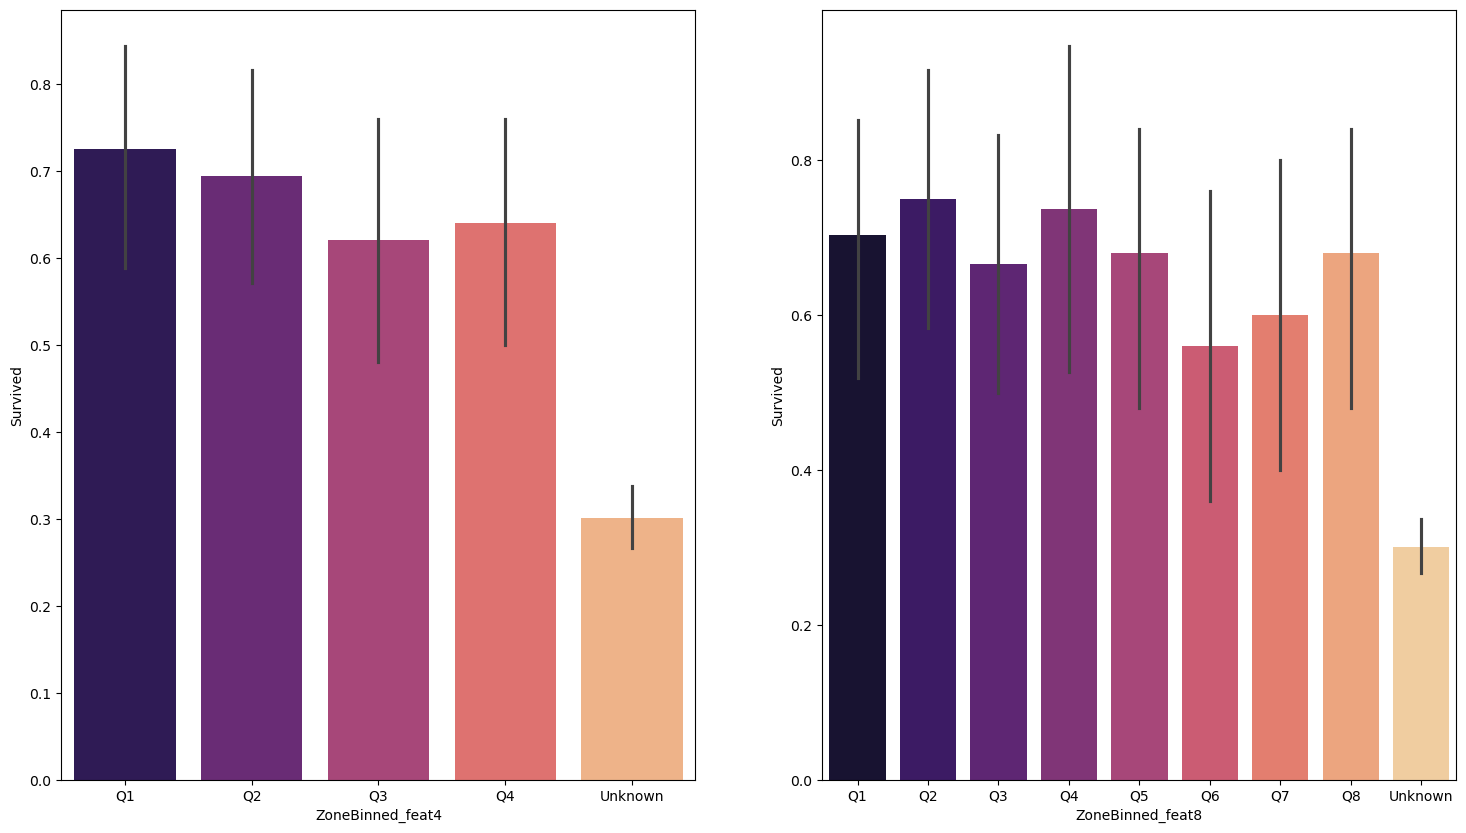

In [281]:
# Plot binned-zone
# Add binned feature
# Add bins
df_scratch['ZoneBinned_feat4'] = pd.qcut(df_scratch['Zone_feat'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
df_scratch['ZoneBinned_feat8'] = pd.qcut(df_scratch['Zone_feat'], q=8, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8'])

# Convert nans to unknown
df_scratch['ZoneBinned_feat4'] = df_scratch['ZoneBinned_feat4'].cat.add_categories(['Unknown']).fillna('Unknown')
df_scratch['ZoneBinned_feat8'] = df_scratch['ZoneBinned_feat8'].cat.add_categories(['Unknown']).fillna('Unknown')


# Make plot
# Create figure
fig, (ax1, ax2)= plt.subplots(1, 2, figsize=(18, 10))

# Add plot for foure bins
sns.barplot(data=df_scratch, x='ZoneBinned_feat4', y='Survived', hue='ZoneBinned_feat4', palette='magma', ax=ax1)
sns.barplot(data=df_scratch, x='ZoneBinned_feat8', y='Survived', hue='ZoneBinned_feat8', palette='magma', ax=ax2)

The plot to the left shows the horizontal cabin locations split into four bins including an *unknown* category. In this case we see a small downwards trend in survival rate, for higher cabin numbers. The right plots bins the continuos feature into eight bins, and we see a more periodic distribution resembling a sine function, it goes up, than down and up again. There is one clear advantage for the eight-binned feature, it is able to pick up on more subtle patterns, however it is also more vulnerable to noise. 

The sine-wave could be explained by the ships structure and the location of lifeboats, if lifeboats were placed systematically with a certain space in between, likely the space between the vertexes in our graph. This would create a center for survival around the lifeboats.

To decide the optimal binning we will use a decision-tree to provide a non-arbitrary optimized set of bins.

<function matplotlib.pyplot.show(close=None, block=None)>

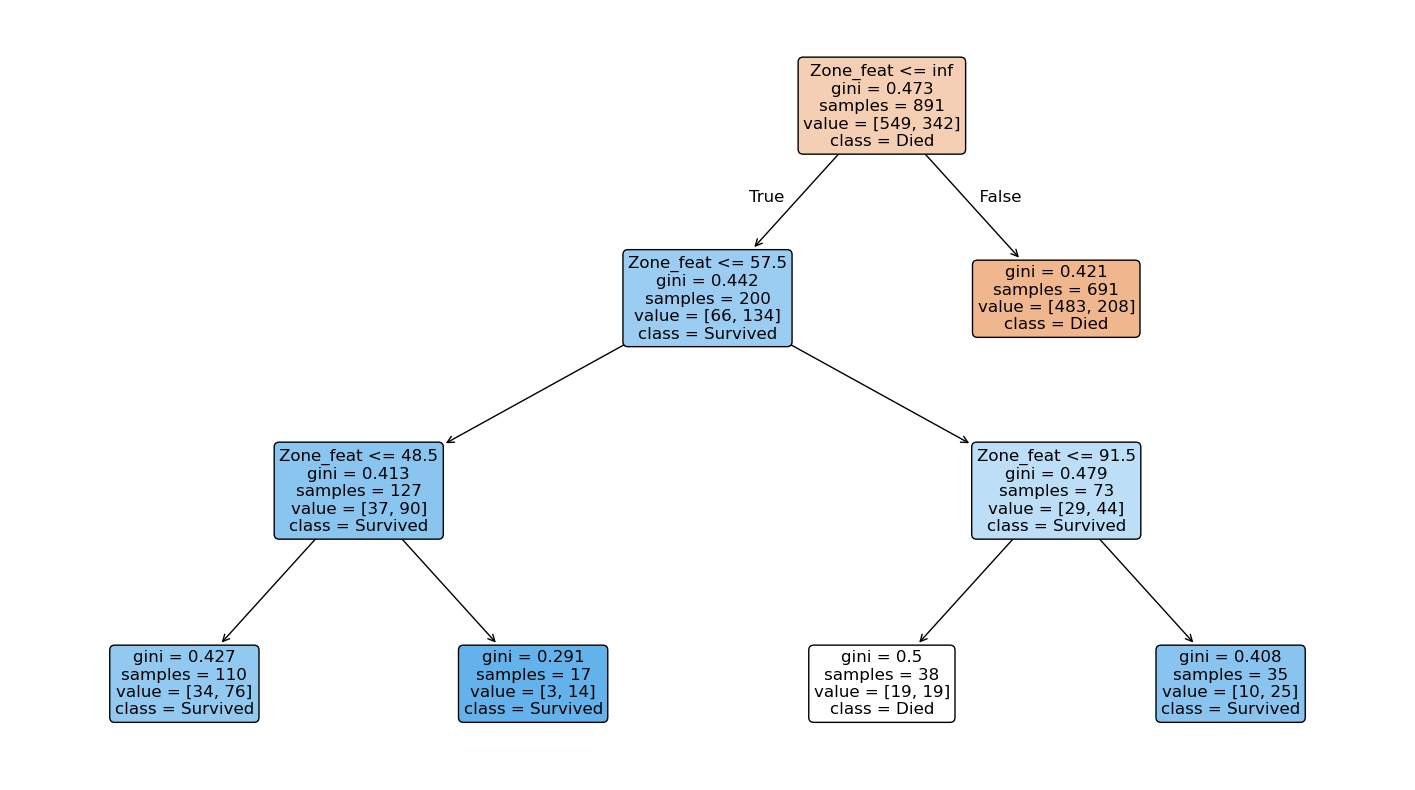

In [282]:
# Imports
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

# Add new optimal binned feat
df_scratch['ZoneTreeBinned_feat'] = df_scratch['Zone_feat'].dropna()

# Prepare data for modelling
X = df_scratch[['Zone_feat']]
y = df_scratch['Survived']

# Initialize model
tree_binner = DecisionTreeClassifier(max_depth=3, min_samples_leaf=10, random_state=43)

# Train model
tree_binner.fit(X, y)

# Plot tree
fig = plt.figure(figsize=(18, 10))
plot_tree(tree_binner, feature_names=['Zone_feat'],class_names=['Died', 'Survived'],filled=True, rounded=True, fontsize=12)

plt.show

One group has a significantly higher survival rate than the others; the tree identified one highly pure node with a Gini value of 0.291, unfortunately, this is also the smallest node. The rest of the groups have Gini values ranging from 0.4 to 0.5 and show no clear pattern. Thus, using the bins created by the tree would likely introduce overfitting.

Since the tree was unable to find a reliable pattern, we will move forward with the eight-bin approach, as it provided an intuitive explanation and a clear pattern in our data.

## 4. Building the Pre-processing and Modeling Pipeline

---

In this section we will construct the components for our final, end-to-end pipeline. 

**Final Pipeline Strategy:**
Based on our initial findings and feature validation, our plan includes the following steps:

*   **Data Cleaning and Imputation:**
    *   Impute missing values for `Age`, `Embarked` and `Fare`. 
    *   Apply a log-transformation to the right-skewed `Fare` feature to normalize its distribution.
    *   Drop the `SibSp` and `Parch` columns. Our validation showed that after adding the powerful `Title` feature, the inclusion of `FamilySize` (derived from `SibSp` and `Parch`) became redundant and slightly degraded model performance.
*   **Advanced Feature Engineering:**
    *   Extract `Title` from `Name`. We will also temporarily extract `Surname` to identify family groups and engineer a `FamilySurvivalRate` feature.
    *   Engineer `Deck` and `Zone` features from `Cabin`, assigning a dedicated category for missing values.
    *   Bin the `Age` feature to capture its non-linear relationship with `Survived`.

**A Note on Imputation of `Age`:** As discovered earlier, `Title` is an excellent proxy for `Age`. Therefore the `Title` feature must be engineered *before* we can accurately impute missing values. This means the implementation will deviate slightly form the sequential order listed above.
    

**A Note on Project Structure:** In a production setting, all source code for the pipeline would typically be organized into a `src`directory for modularity, reusability and testing. However, for the sake of clarity and simplicity for the reader, we will define these components below. This allows the reader to follow each step of the logic directly.

### 4.1. Custom Transformer

To start we will begin by creating our custom transformers for our engineered features.

The first transformer we will implement is `TitleExtractor`.

**A Note on Caching:** To improve efficiency especially for large training sets, we can able caching in our pipeline using the `memory` parameter. This prevents the pipeline from re-running the same pre-processing steps repeatedly. Due to the small size of our dataset, it is an unnecessary optimization which we will not implement.

In [283]:
# Lets define a small test-sample for our transformers -- To test on the go that they work as expected
X_train_sample = df_train.iloc[0:800].copy()
y_train_sample = X_train_sample.pop('Survived')

X_test_sample = df_train.iloc[800:891].copy().drop('Survived', axis=1)

In [284]:
class TitleExtractor(BaseEstimator,  TransformerMixin):
    def __init__(self, rare_threshold=10):
        self.rare_threshold = rare_threshold

        # Titles with same meaning
        self.title_synonym_mapping_ = {
            'Mlle.': 'Miss.',
            'Ms.': 'Miss.',
            'Mme.': 'Mrs.'
        }

    def fit(self, X, y=None):
        titles = X['Name'].str.extract(pat=' ([A-Za-z]+\.)', expand=False)
        titles = titles.replace(self.title_synonym_mapping_)
        self.non_rare_titles_ = titles.value_counts()[lambda x: x >= self.rare_threshold].index
        return self
    
    def transform(self, X, y=None):
        # Copy to avoid modifying original
        X_copy = X.copy()
        # Extract title 
        X_copy['Title_feat'] = X_copy['Name'].str.extract(pat=' ([A-Za-z]+\.)', expand=False)
        
        # Swap titles with 'Rare' and synonym
        X_copy['Title_feat'] = X_copy['Title_feat'].replace(self.title_synonym_mapping_)


        X_copy['Title_feat'] = X_copy['Title_feat'].apply(lambda x: x if x in self.non_rare_titles_ else 'Rare')

        return X_copy

In [285]:
# Check for train
title_transformer = TitleExtractor(rare_threshold=5)
title_transformer.fit(X_train_sample, y_train_sample)
train_transformed_title = title_transformer.transform(X_train_sample)
display(train_transformed_title.head(20))

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title_feat
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr.
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs.
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss.
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs.
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr.
5,6,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,Mr.
6,7,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,Mr.
7,8,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,Master.
8,9,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,Mrs.
9,10,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,Mrs.


In [286]:
# Check for test
test_transformed_title= title_transformer.transform(X_test_sample)
display(test_transformed_title.head(20))

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title_feat
800,801,2,"Ponesell, Mr. Martin",male,34.00,0,0,250647,13.0000,NaN,S,Mr.
801,802,2,"Collyer, Mrs. Harvey (Charlotte Annie Tate)",female,31.00,1,1,C.A. 31921,26.2500,NaN,S,Mrs.
802,803,1,"Carter, Master. William Thornton II",male,11.00,1,2,113760,120.0000,B96 B98,S,Master.
803,804,3,"Thomas, Master. Assad Alexander",male,0.42,0,1,2625,8.5167,NaN,C,Master.
804,805,3,"Hedman, Mr. Oskar Arvid",male,27.00,0,0,347089,6.9750,NaN,S,Mr.
805,806,3,"Johansson, Mr. Karl Johan",male,31.00,0,0,347063,7.7750,NaN,S,Mr.
806,807,1,"Andrews, Mr. Thomas Jr",male,39.00,0,0,112050,0.0000,A36,S,Mr.
807,808,3,"Pettersson, Miss. Ellen Natalia",female,18.00,0,0,347087,7.7750,NaN,S,Miss.
808,809,2,"Meyer, Mr. August",male,39.00,0,0,248723,13.0000,NaN,S,Mr.
809,810,1,"Chambers, Mrs. Norman Campbell (Bertha Griggs)",female,33.00,1,0,113806,53.1000,E8,S,Mrs.


The next step is to implement `FamilySurvivalRateExtractor`.

In [287]:
class FamilySurvialRateExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, drop_surname=True, smooth_factor=1):
        self.drop_surname = drop_surname
        self.smooth_factor = smooth_factor

    def fit(self, X, y):
        X_temp = pd.concat([X, y], axis=1)

        X_temp['FamilyID_temp'] = self.__get_family_id(X)


        self.family_stats_ = X_temp.groupby('FamilyID_temp').agg(
            FamilySize_temp = ('Survived', 'size'), 
            FamilySurvivalCount_temp = ('Survived', 'sum')
        )
    
        self.global_survival_rate_ = y.mean()
        self.training_index_ = X.index
        self.y_train_ = y

        self.alone_survival_rate_ = self.family_stats_[self.family_stats_['FamilySize_temp'] == 1]['FamilySurvivalCount_temp'].mean()

        return self

    def transform(self, X, y=None):
        X_copy = X.copy()

        X_copy['FamilyID_temp'] = self.__get_family_id(X)

        X_copy = X_copy.merge(self.family_stats_, on='FamilyID_temp', how='left')

        # Different calculation for passengers from training set -- avoid data leakage
        if X.index.equals(self.training_index_):
            X_copy['FamilySurvivalCount_temp'] -= self.y_train_
            X_copy['FamilySize_temp'] -= 1

        numerator = X_copy['FamilySurvivalCount_temp'] 
        denominator = X_copy['FamilySize_temp']
        
        # Apply smoothing
        smoothed_numerator = numerator + (self.smooth_factor * self.global_survival_rate_)
        smoothed_denominator = denominator + self.smooth_factor

        # Calculate FamilySurvivalRate
        X_copy['FamilySurvivalRate_feat'] = smoothed_numerator / smoothed_denominator

        # For passengers without a family from training
        X_copy['FamilySurvivalRate_feat'] = X_copy['FamilySurvivalRate_feat'].fillna(self.global_survival_rate_)

        # For passengers which travel alone we will overwrite global_survival_rate_
        is_alone_mask = (X_copy.groupby('FamilyID_temp')['FamilyID_temp'].transform('count') == 1) & (X_copy['FamilySize_temp'] == 0 | X_copy['FamilySize_temp'].isna())

        X_copy.loc[is_alone_mask, 'FamilySurvivalRate_feat'] = self.alone_survival_rate_

        # Columns to drop
        columns_to_drop = ['FamilySurvivalCount_temp', 'FamilySize_temp', 'FamilyID_temp']
        
        # Clean df
        X_copy = X_copy.drop(columns_to_drop, axis=1)

        return X_copy

    def __get_surname(self, X):
        # Extract surname
        data = X.copy()
        return data['Name'].str.extract(pat=r'^(.+)?,', expand=False)
    
    def __get_family_id(self, X):
        return self.__get_surname(X) + '_' + X['Pclass'].astype(str)



In [288]:
# Check for train
family_survial_rate_transformer = FamilySurvialRateExtractor(smooth_factor=2)
family_survial_rate_transformer.fit(X_train_sample, y_train_sample)
train_transformed_family_survival_rate = family_survial_rate_transformer.transform(X_train_sample)
display(train_transformed_family_survival_rate.head(20))

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySurvivalRate_feat
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0.256667
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0.370656
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0.370656
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0.256667
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0.370656
5,6,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,0.442500
6,7,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,0.370656
7,8,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,0.154000
8,9,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,0.295000
9,10,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,0.256667


In [289]:
# Check for test
test_transformed_family_survival_rate = family_survial_rate_transformer.transform(X_test_sample)
display(test_transformed_family_survival_rate.head(20))

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySurvivalRate_feat
0,801,2,"Ponesell, Mr. Martin",male,34.00,0,0,250647,13.0000,NaN,S,0.385000
1,802,2,"Collyer, Mrs. Harvey (Charlotte Annie Tate)",female,31.00,1,1,C.A. 31921,26.2500,NaN,S,0.442500
2,803,1,"Carter, Master. William Thornton II",male,11.00,1,2,113760,120.0000,B96 B98,S,0.754000
3,804,3,"Thomas, Master. Assad Alexander",male,0.42,0,1,2625,8.5167,NaN,C,0.385000
4,805,3,"Hedman, Mr. Oskar Arvid",male,27.00,0,0,347089,6.9750,NaN,S,0.385000
5,806,3,"Johansson, Mr. Karl Johan",male,31.00,0,0,347063,7.7750,NaN,S,0.192500
6,807,1,"Andrews, Mr. Thomas Jr",male,39.00,0,0,112050,0.0000,A36,S,0.590000
7,808,3,"Pettersson, Miss. Ellen Natalia",female,18.00,0,0,347087,7.7750,NaN,S,0.385000
8,809,2,"Meyer, Mr. August",male,39.00,0,0,248723,13.0000,NaN,S,0.385000
9,810,1,"Chambers, Mrs. Norman Campbell (Bertha Griggs)",female,33.00,1,0,113806,53.1000,E8,S,0.590000


Since we know have implemented TitleExtractor for `Name` we can now use `Title` to impute `Age`. The next transformer to build is therefore `AgeImputer`.

In [290]:
class AgeImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y):
        X_temp = X.copy()
        self.median_by_title_ = X_temp.groupby('Title_feat')['Age'].median()
        return self
    
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_copy['Age'] = X_copy['Age'].fillna(X_copy['Title_feat'].map(self.median_by_title_))
        return X_copy



In [291]:
age_imputer_transformer = AgeImputer()
age_imputer_transformer.fit(train_transformed_title, y_train_sample)
train_transformed_age_imputed = age_imputer_transformer.transform(train_transformed_title)
print(f'''Missing values in Age: {train_transformed_age_imputed['Age'].isnull().sum()}''')
train_transformed_age_imputed.head(20)
 

Missing values in Age: 0


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title_feat
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr.
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs.
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss.
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs.
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr.
5,6,3,"Moran, Mr. James",male,29.0,0,0,330877,8.4583,NaN,Q,Mr.
6,7,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,Mr.
7,8,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,Master.
8,9,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,Mrs.
9,10,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,Mrs.


In [292]:
test_transformed_age_imputed = age_imputer_transformer.transform(test_transformed_title)
print(f'''Missing values in Age: {test_transformed_age_imputed['Age'].isnull().sum()}''')
test_transformed_age_imputed.head(20)

Missing values in Age: 0


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title_feat
800,801,2,"Ponesell, Mr. Martin",male,34.00,0,0,250647,13.0000,NaN,S,Mr.
801,802,2,"Collyer, Mrs. Harvey (Charlotte Annie Tate)",female,31.00,1,1,C.A. 31921,26.2500,NaN,S,Mrs.
802,803,1,"Carter, Master. William Thornton II",male,11.00,1,2,113760,120.0000,B96 B98,S,Master.
803,804,3,"Thomas, Master. Assad Alexander",male,0.42,0,1,2625,8.5167,NaN,C,Master.
804,805,3,"Hedman, Mr. Oskar Arvid",male,27.00,0,0,347089,6.9750,NaN,S,Mr.
805,806,3,"Johansson, Mr. Karl Johan",male,31.00,0,0,347063,7.7750,NaN,S,Mr.
806,807,1,"Andrews, Mr. Thomas Jr",male,39.00,0,0,112050,0.0000,A36,S,Mr.
807,808,3,"Pettersson, Miss. Ellen Natalia",female,18.00,0,0,347087,7.7750,NaN,S,Miss.
808,809,2,"Meyer, Mr. August",male,39.00,0,0,248723,13.0000,NaN,S,Mr.
809,810,1,"Chambers, Mrs. Norman Campbell (Bertha Griggs)",female,33.00,1,0,113806,53.1000,E8,S,Mrs.


The last custom transformer we need to implement is `ExtractCabinLocation`.

In [293]:
class CabinLocationExtractor:
    def __init__(self, drop_original=True):
        self.drop_original = True
    
    def fit(self, X, y):
        pass

    def transform(self, X, y=None):
        X_copy = X.copy()
        X_copy['Deck_feat'] = X_copy['Cabin'].str.extract(pat=r'^([A-Za-z])?', expand=False).fillna('U')
        X_copy['Zone_feat'] = pd.to_numeric(
            X_copy['Cabin'].str.extract(pat=r'([0-9]+)', expand=False),
            errors='coerce'
            )
        return X_copy

In [294]:
cabin_location_transformer = CabinLocationExtractor()
cabin_location_transformer.fit(X_train_sample, y_train_sample)
train_transformed_cabin = cabin_location_transformer.transform(X_train_sample)
display(train_transformed_cabin.head(20))

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck_feat,Zone_feat
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,U,NaN
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C,85.0
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,U,NaN
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C,123.0
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,U,NaN
5,6,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,U,NaN
6,7,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,E,46.0
7,8,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,U,NaN
8,9,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,U,NaN
9,10,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,U,NaN


We will handle missing values in the pipeline, probably binning numerical features, with an extra bin for missing values.

### 4.2 Building the Pipeline

In [295]:
feature_engineering_pipeline = Pipeline(steps=[
    ('title_extractor', TitleExtractor()),
    ('age_imputer', AgeImputer()),
    ('cabin_location_extractor', CabinLocationExtractor())
])

In [298]:
NUMERICAL_FEATURES_TO_SCALE = ['Fare']
CATEGORICAL_FEATURES = ['Sex',
                        'Embarked',
                        'Pclass',
                        'Title',
                        ]
AGE_TO_BIN = ['Age']
ZONE_TO_BIN = ['Zone_feat']

In [299]:
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [300]:
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [301]:
# Simple function for pd.cut
def apply_pd_cut(X, bins, labels):
    series = pd.Series(X[:, 0])
    binned_series = pd.cut(series, bins=bins, labels=labels, right=True, include_lowest=True)
    return binned_series.to_numpy().reshape(-1, 1)

# Bins for Age
# Infant: 0-5, Child: 6-12, young-adult: 13-25, adult: 26-50, elder: 51->
AGE_BINS = [0, 5, 12, 25, 50, np.inf]
AGE_LABELS = ['Infant', 'Child', 'Young-Adult', 'Adult', 'Senior']

age_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('binner', FunctionTransformer(apply_pd_cut, kw_args={'bins': AGE_BINS, 'labels': AGE_LABELS})),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [ ]:
preprocesser = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, NUMERICAL_FEATURES), 
        ('cat', categorical_pipeline, CATEGORICAL_FEATURES)
    ],
    remainder='drop'
)

grand_pipeline = Pipeline(steps=[
    ('feature_engineering', feature_engineering_pipeline),
    ('preprocessing', preprocesser)
])

NameError: name 'numerical_pipeline' is not defined

## 3. Data Cleaning and Imputation

---

Our exploratory data analysis revealed several data quality issues that must be resolved before feature engineering can start:

1.  **Handle Outliers and Skewed data in `Fare`:** Apply a log-transformation to the column.
2.  **Impute `Embarked`:** Fill the two missing values using the mode.
3.  **Impute `Age`:** Impute the missing values in `Age`, using the median age grouped by `Title` and `Pclass`.

**Note on `Cabin`:** Due to the severe amount of missing data (~77%), a simple imputation is not feasible. Instead, we will treat this as a feature engineering task by extracting positional information to create two new features: `Deck` and `Zone`. For passengers with missing cabin data, these new features will be assigned an 'Unknown' class. Consequently, the handling of `Cabin` is deferred to the `Feature Engineering` section.